In [5]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
from scipy.signal import find_peaks
import seaborn as sns
import glob as glob
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Loading SST data

In [9]:
rep_sst = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/SST/v2.1_avhrr/For_MITgcm'
content_sst = sorted(glob.glob(rep_sst+"/*.nc"))
#content_sst

In [39]:
ds = xr.open_mfdataset(content_sst)
ds

<xarray.Dataset>
Dimensions:  (time: 153, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2022-09-01T12:00:00 ... 2023-01-31T12:00:00
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20220901.nc
    naming_authority:           gov.noaa.ncei
    ...                         ...
    time_coverage_start:        2022-09-01T00:00:00Z
    time_coverage_end:          2022-09-01T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR

In [16]:
SST = ds.sst.squeeze()
Lon = ds.lon
Lat = ds.lat
print(SST.shape,Lon.shape,Lat.shape)

(153, 720, 1440) (1440,) (720,)


# Loading cCTD data

In [11]:
## SASSIE final data collected files directory ---------------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'#|
CastAway_CTD    = 'CastAway_CTD/SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc'#----------------|
ctd = xr.open_dataset(Final_SASSIE+CastAway_CTD)
lon_ctd = ctd.longitude
lat_ctd = ctd.latitude

In [136]:
tmp_pt

<xarray.DataArray 'sst' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 2022-09-01T12:00:00
    zlev       float32 0.0
    lat        float32 73.12
    lon        float32 0.125
    longitude  float64 -146.8
    latitude   float64 73.06
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

In [185]:
SST

<xarray.DataArray 'sst' (time: 153, lat: 720, lon: 1440)>
dask.array<getitem, shape=(153, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-09-01T12:00:00 ... 2023-01-31T12:00:00
    zlev     float32 0.0
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

In [178]:
i=0
#tmp = SST[0,600:675,750:950]
tmp = SST[0]
tmp_pts = []
sst_lons = []
sst_lats = []
for i in range(250):
    tmp_pt = tmp.sel(lon=lon_ctd[i]+360,lat=lat_ctd[i],method='nearest')
    sst_lats.append(tmp_pt.latitude.values)
    sst_lons.append(tmp_pt.longitude.values)
    tmp_pts.append(tmp_pt.compute())
    
sst_lats=np.array(sst_lats)
sst_lons=np.array(sst_lons)
tmp_pts=np.array(tmp_pts)

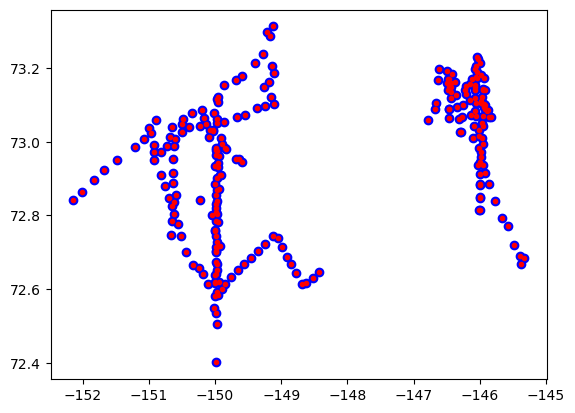

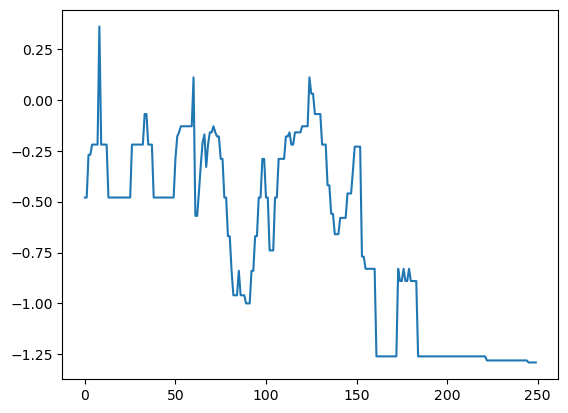

In [179]:
plt.plot(sst_lons, sst_lats, 'bo')
plt.plot(lon_ctd, lat_ctd, 'r.')

plt.figure();
plt.plot(tmp_pts)

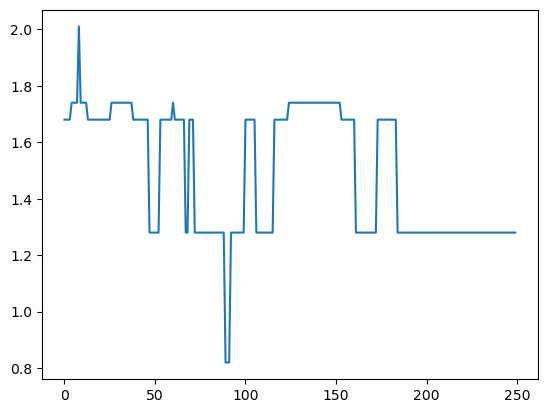

In [132]:
plt.plot(np.array(tmp_pts))

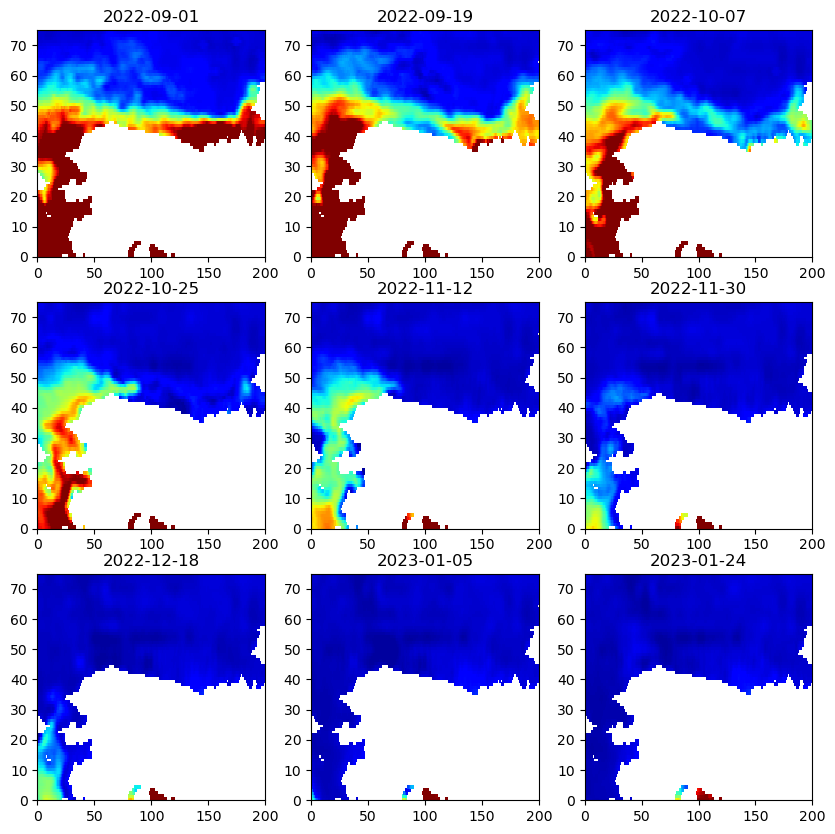

In [111]:
ij=1;
#plt.imshow(SST[ij,:,:], origin='lower')
#plt.figure();
#plt.imshow(SST[ij,600:,750:950], origin='lower',vmin=-2,vmax=5, cmap='jet');plt.colorbar()
#
ix = np.linspace(0, 145, 9)
ix = ix.astype('int')
f, axs = plt.subplots(3,3,figsize=[10,10])
axs=axs.ravel()
for i in range(len(ix)):
    axs[i].pcolor(SST[ix[i],600:675,750:950],vmin=-2,vmax=5, cmap='jet');
    axs[i].set_title(str(SST.time[ix[i]].values)[:10])


In [128]:
print(i)
SST[ij,:,:].sel(lon=lon_ctd[i],lat=lat_ctd[i],method='nearest').values

44


array(6.68, dtype=float32)

In [186]:
l1.values

array(-1.74, dtype=float32)

In [180]:
SST_colo = np.ndarray(shape=(lon_ctd.size,SST.shape[0]),dtype=float)*np.nan

for ij in np.arange(SST.shape[0]):
    for i in np.arange(lon_ctd.size):
        l1 = SST[ij,:,:].sel(lon=lon_ctd[i]+360,lat=lat_ctd[i],method='nearest')
        SST_colo[i,ij] = l1.values

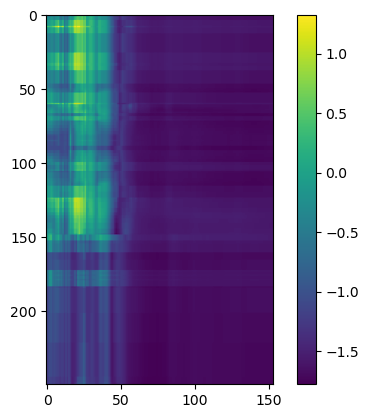

In [182]:
plt.imshow(SST_colo)
plt.colorbar()

In [47]:
#ds.time

In [183]:
## defining xr dataset for coords and variables
xrds = xr.Dataset(
    coords= dict(time = ds.time,  longitude = np.array(lon_ctd), latitude = np.array(lat_ctd)),
    data_vars = dict(
        SST_colo_ctd =(["longitude","time"],SST_colo),
        )
    )
## adding vriables attrs
xrds['time'].attrs['axis']  = 'T'
#xrds['time'].attrs['units'] = 'days since 1950-01-01'
xrds['time'].attrs['standard_name'] = 'time'
xrds['time'].attrs['long_name'] = 'time following Model output time'
xrds['time'].attrs['coverage_content_type'] = 'coordinate'
#----------------------------------------------------------------------
xrds['longitude'].attrs = {
    'axis':'X',
    'units':'degree_east',
    'standard_name':'longitude',
    'long_name':'longitude',
    'coverage_content_type':'coordinate'}
#----------------------------------------------------------------------
xrds['latitude'].attrs = {
    'axis':'Y',
    'units':'degree_north',
    'standard_name':'latitude',
    'long_name':'latitude',
    'coverage_content_type':'coordinate'}
#----------------------------------------------------------------------
xrds['SST_colo_ctd'].attrs = {
    'units':'%',
    'standard_name':'SST',
    'long_name':'SST data colocated to the CTD profiles location',
    'coverage_content_type':'physicalMeasurement',
    'valid_min':int(-10),
    'valid_max':int(50),
    'coordinates':'(latitude longitude) time'}
#----------------------------------------------------------------------
#--- Save the data in ".nc" file:=>  to_netcdf('filename.nc',encoding=my_encoding)
filename = "SST_time_series_from_NOAA_OISST_on_uCTD_positions.nc"
#--------------------------------------------------------------------------------------------|
xrds.to_netcdf(rep_sst+'/Coloc_cCTD/'+filename)#,'w'

In [184]:
xr.open_dataset(rep_sst+'/Coloc_cCTD/'+filename)#,'w'

<xarray.Dataset>
Dimensions:       (longitude: 250, time: 153, latitude: 250)
Coordinates:
  * time          (time) datetime64[ns] 2022-09-01T12:00:00 ... 2023-01-31T12...
  * longitude     (longitude) float64 -150.0 -150.0 -150.2 ... -146.7 -146.8
  * latitude      (latitude) float64 72.98 72.88 72.84 72.8 ... 73.1 73.09 73.06
Data variables:
    SST_colo_ctd  (longitude, time) float64 ...

In [51]:
SST.shape

(153, 720, 1440)

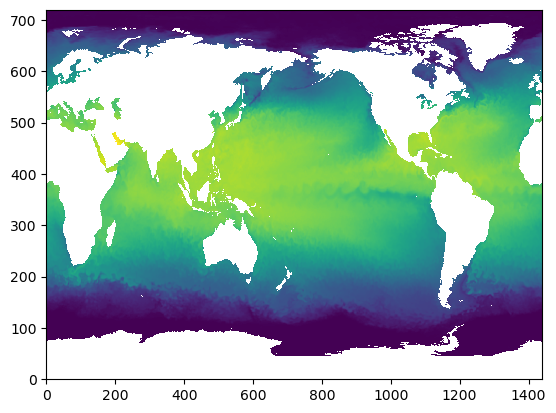

In [53]:
plt.pcolormesh(SST[0,:,:])

In [63]:
ds.time[10]

<xarray.DataArray 'time' ()>
array('2022-09-11T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-09-11T12:00:00
Attributes:
    long_name:  Center time of the day

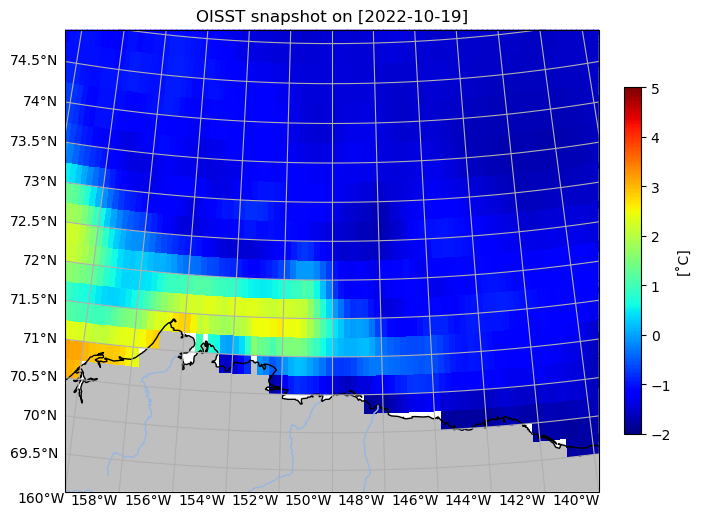

In [73]:
t = 48
lon0=-150
lonmapmin=-160
lonmapmax=-140
latmapmin=69
latmapmax=75
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.Stereographic(central_longitude=lon0))
ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree())
#ax.set_extent([-152, -148, 73, 74], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax.coastlines('10m',zorder=2)
ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=2)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
gl.ylabel_style = {'size': 10, 'color': 'k','rotation':0}
#----------------------------------------------------------------------------#
gl.top_labels = False
gl.right_labels = False
#----------------------------------------------------------------------------#
plt.title('OISST snapshot on ['+str(np.array(ds.time[t]))[slice(0,10,1)]+']')
##############################################################################
cb = ax.pcolormesh(Lon,Lat,SST[t,:,:],transform=ccrs.PlateCarree(),
                    cmap='jet', zorder=1, vmin=-2,vmax=5)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[˚C]", orientation="vertical",shrink=0.75)